## **Practice Ensemble Model Boosting**

## **Import libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, confusion_matrix, recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

## **Load & explore dataset**

In [4]:
df = pd.read_csv('churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
print(df['Exited'].value_counts())
print()
print(df['Exited'].value_counts()/len(df['Exited'])*100)

0    7963
1    2037
Name: Exited, dtype: int64

0    79.63
1    20.37
Name: Exited, dtype: float64


In [7]:
cat_features = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
cat_features

['Surname', 'Geography', 'Gender']

In [9]:
# Check Unique data on categorikal features
for i in cat_features:
    print(f'Total unique values in {i}: ', df[i].nunique())
    print(f'Unique values: ', df[i].unique())
    print()

Total unique values in Surname:  2932
Unique values:  ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']

Total unique values in Geography:  3
Unique values:  ['France' 'Spain' 'Germany']

Total unique values in Gender:  2
Unique values:  ['Female' 'Male']



In [10]:
num_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['Exited']))]
num_features

['RowNumber',
 'CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [11]:
df.corr()['Exited']

RowNumber         -0.016571
CustomerId        -0.006248
CreditScore       -0.027094
Age                0.285323
Tenure            -0.014001
Balance            0.118533
NumOfProducts     -0.047820
HasCrCard         -0.007138
IsActiveMember    -0.156128
EstimatedSalary    0.012097
Exited             1.000000
Name: Exited, dtype: float64

In [12]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [13]:
df.groupby('Geography').sum()['Exited']

Geography
France     810
Germany    814
Spain      413
Name: Exited, dtype: int64

In [14]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## **EDA**

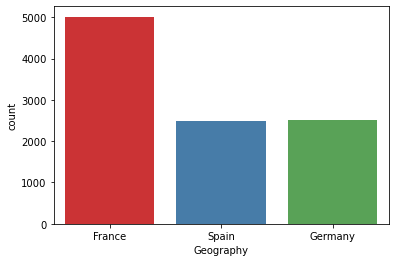

In [15]:
sns.set_palette('Set1')

sns.countplot(x='Geography', data=df);

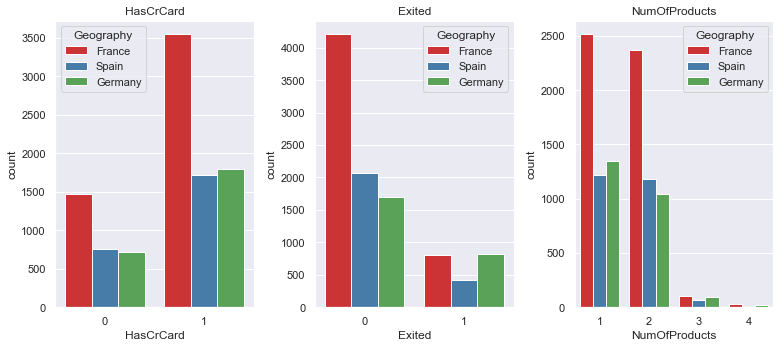

In [16]:
features = ['HasCrCard', 'Exited', 'NumOfProducts']
plt.figure(figsize=(11, 5))
sns.set(palette='Set1')
plotnumber = 1

for feature in features:
    ax = plt.subplot(1, 3, plotnumber)
    sns.countplot(x=feature, hue='Geography', data=df)
    plt.xlabel(feature)
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout()

There so many people have credit card esspecially in Frace Exited

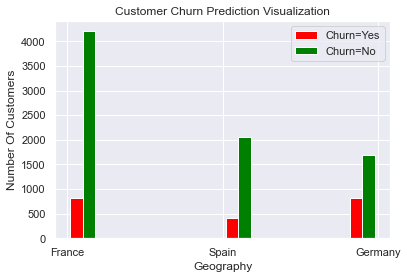

In [17]:
geo_churn_no = df[df.Exited==0]['Geography']
geo_churn_yes = df[df.Exited==1]['Geography']

plt.xlabel('Geography')
plt.ylabel('Number Of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([geo_churn_yes, geo_churn_no], color=['red', 'green'], label=['Churn=Yes', 'Churn=No'])
plt.legend()

German has biggest ratio churn

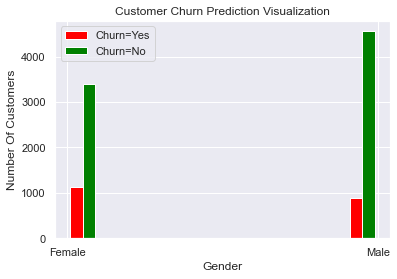

In [18]:
gender_churn_no = df[df.Exited==0]['Gender']
gender_churn_yes = df[df.Exited==1]['Gender']

plt.xlabel('Gender')
plt.ylabel('Number Of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([gender_churn_yes, gender_churn_no], color=['red', 'green'], label=['Churn=Yes', 'Churn=No'])
plt.legend()

Gender doesn't have spesific impact on Churn

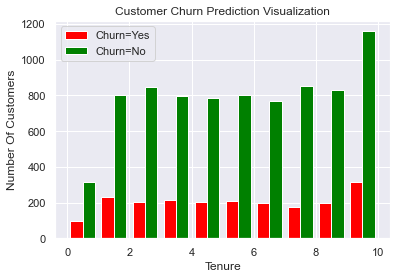

In [25]:
tenure_churn_no = df[df.Exited==0].Tenure
tenure_churn_yes = df[df.Exited==1].Tenure

plt.xlabel('Tenure')
plt.ylabel('Number Of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([tenure_churn_yes, tenure_churn_no], color=['red', 'green'], label=['Churn=Yes', 'Churn=No'])
plt.legend()

we dint see spesific correlation between tenure and churn, but it's kinda the longger tenure is most likely churn happen

<AxesSubplot:xlabel='IsActiveMember', ylabel='Age'>

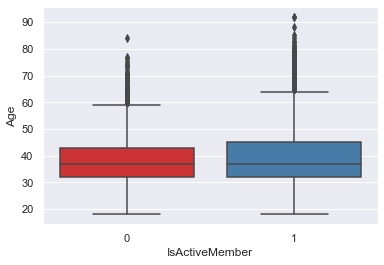

In [20]:
sns.boxplot(x='IsActiveMember', y='Age', data=df)

So many outlier in Age, Churn or not

<AxesSubplot:xlabel='NumOfProducts', ylabel='EstimatedSalary'>

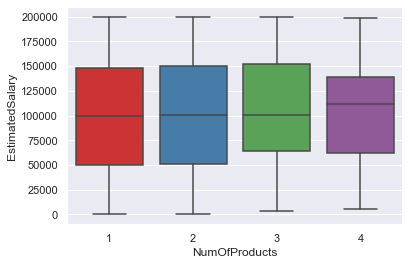

In [22]:
sns.boxplot(x='NumOfProducts', y='EstimatedSalary', data=df)

<AxesSubplot:xlabel='Age', ylabel='Balance'>

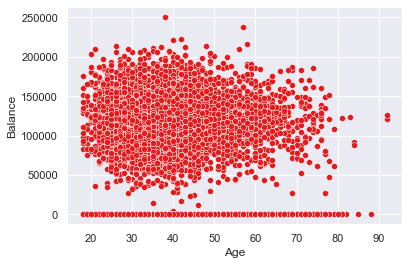

In [23]:
sns.scatterplot(x='Age', y='Balance', data=df)

There doest have spesific pattern between age and balance, there someone who's old but doesnt have much balance, and goes both ways

## **Drop unnecessary features**

In [28]:
# Drop some columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## **Data splitting**

In [29]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

In [30]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    stratify=y,
    test_size=0.2,
    random_state=0
)

## **Data preprocessing**

In [31]:
# Transformer scheme
onehot = OneHotEncoder(drop='first')

transformer = ColumnTransformer([
    ('onehot', onehot, ['Geography', 'Gender'])
], remainder='passthrough')

In [32]:
# Fit and transform transformer
X_train_prep = transformer.fit_transform(X_train)
X_test_prep = transformer.transform(X_test)

In [33]:
# Scaling
scaler = MinMaxScaler()

X_train_prep_scaled = scaler.fit_transform(X_train_prep)
X_test_prep_scaled = scaler.transform(X_test_prep)

## **Model benchmark**

In [34]:
# DecsionTree
tree = DecisionTreeClassifier(random_state=0)

# RandomForest
rf = RandomForestClassifier(random_state=0)

# Adaboost
ada = AdaBoostClassifier(tree, random_state=0)

# Gradientboost
gbc = GradientBoostingClassifier(random_state=0)

# ExtremeGradientBosst
xgbc = XGBClassifier(random_state=0, verbosity=0)

In [35]:
# Define imbalanced treatment method
models = [tree, rf, ada, gbc, xgbc]
score = []
nilai_mean = []
nilai_std = []

for i in models:
    smote = SMOTE(random_state=0)
    skfold = StratifiedKFold(n_splits=5)
    estimator = Pipeline([
        ('balancing', smote),
        ('model', i)
    ])

    model_cv = cross_val_score(estimator, X_train_prep_scaled, y_train, cv=skfold, scoring='recall', error_score='raise')
    score.append(model_cv)
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

In [36]:
pd.DataFrame({
    'model':['tree', 'rf',' ada', 'gbc', 'xgbc'],
    'mean':nilai_mean,
    'std':nilai_std
})

,model,mean,std
0,tree,0.572393,0.023729
1,rf,0.607975,0.018849
2,ada,0.576074,0.028867
3,gbc,0.656442,0.025443
4,xgbc,0.553988,0.012362


Model GradientBoost dan RandomForest dipilih menjadi 2 model paling optimal karena memiliki nilai recall rata-rata paling tinggi.

## **Model Performance on Test Set**

In [37]:
models={
    'GradientBoosting': GradientBoostingClassifier(random_state=0),
    'Random Forest': RandomForestClassifier(random_state=0),  
}

score=[]

for i in models:
    models[i].fit(X_train_prep_scaled, y_train)
    y_pred=models[i].predict(X_test_prep_scaled)
    score.append([f1_score(y_test, y_pred)])

score_before_tuning = pd.DataFrame(score, columns=['Recall'], index = models.keys())
score_before_tuning


,Recall
GradientBoosting,0.555382
Random Forest,0.578462


## **Tuning the model benchmark**

In [38]:
# Hyperparameter space GBC
hyperparam_space_gbc = [
    {'clf__learning_rate':[0.1],'clf__n_estimators':[200],'clf__max_depth':[3,4,5]},
    {'clf__learning_rate':[0.05],'clf__n_estimators':[400],'clf__max_depth':[3,4,5]},
    {'clf__learning_rate':[0.01],'clf__n_estimators':[2000],'clf__max_depth':[3,4,5]},
    {'clf__learning_rate':[0.005],'clf__n_estimators':[4000],'clf__max_depth':[3,4,5]}
]

# Hyperparameter space RF

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(1, 100, num = 11)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

hyperparam_space_rf = {
    'clf__n_estimators': n_estimators,
    'clf__max_features': max_features,
    'clf__max_depth': max_depth,
    'clf__min_samples_split': min_samples_split,
    'clf__min_samples_leaf': min_samples_leaf,
    'clf__bootstrap': bootstrap
}

In [39]:
gbc = GradientBoostingClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)

# Create the algorithm chains
smote = SMOTE()
estimator_gbc = Pipeline([('balancing', smote), ('clf', gbc)])
estimator_rf = Pipeline([('balancing', smote), ('clf', rf)])

# Stratified cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=0)

# Hyperparameter tuning
random_gbc = RandomizedSearchCV(
    estimator_gbc, # model to tune
    param_distributions = hyperparam_space_gbc, # hyperparameter space
    cv = skf, # evaluation method
    scoring = 'recall', # metrics
    n_jobs = -1 # use all cores
)

random_rf = RandomizedSearchCV(
    estimator_rf, # model to tune
    param_distributions = hyperparam_space_rf, # hyperparameter space
    cv = skf, # evaluation method
    scoring = 'recall', # metrics
    n_jobs = -1 # use all cores
)

In [40]:
random_gbc.fit(X_train_prep_scaled, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('balancing', SMOTE()),
                                             ('clf',
                                              GradientBoostingClassifier(random_state=0))]),
                   n_jobs=-1,
                   param_distributions=[{'clf__learning_rate': [0.1],
                                         'clf__max_depth': [3, 4, 5],
                                         'clf__n_estimators': [200]},
                                        {'clf__learning_rate': [0.05],
                                         'clf__max_depth': [3, 4, 5],
                                         'clf__n_estimators': [400]},
                                        {'clf__learning_rate': [0.01],
                                         'clf__max_depth': [3, 4, 5],
                                         'clf__n_estimators': [2000]},
                                        {

It may took a while for this to run be patience

In [41]:
random_rf.fit(X_train_prep_scaled, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('balancing', SMOTE()),
                                             ('clf',
                                              RandomForestClassifier(random_state=0))]),
                   n_jobs=-1,
                   param_distributions={'clf__bootstrap': [True, False],
                                        'clf__max_depth': [2, 4, 6, 8, 10],
                                        'clf__max_features': ['auto', 'sqrt'],
                                        'clf__min_samples_leaf': [1, 2, 4],
                                        'clf__min_samples_split': [1, 10, 20,
                                                                   30, 40, 50,
                                                                   60, 70, 80,
                                                                   90, 100],
                                        'clf__n_estimators': 

In [42]:
print('GBC')
print('Best_score:', random_gbc.best_score_)
print('Best_params:', random_gbc.best_params_)
print()
print('RF')
print('Best_score:', random_rf.best_score_)
print('Best_params:', random_rf.best_params_)

GBC
Best_score: 0.6122699386503068
Best_params: {'clf__n_estimators': 400, 'clf__max_depth': 3, 'clf__learning_rate': 0.05}

RF
Best_score: 0.7042944785276074
Best_params: {'clf__n_estimators': 2000, 'clf__min_samples_split': 30, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 6, 'clf__bootstrap': True}


## **Use the best estimator to predict test set**

In [43]:
gbc_tuning = random_gbc.best_estimator_
gbc_tuning.fit(X_train_prep_scaled, y_train)

rf_tuning = random_rf.best_estimator_
rf_tuning.fit(X_train_prep_scaled, y_train)

y_pred_gbc_tuning = gbc_tuning.predict(X_test_prep_scaled)
y_pred_rf_tuning = rf_tuning.predict(X_test_prep_scaled)

recall_gbc_tuning = recall_score(y_test, y_pred_gbc_tuning)
recall_rf_tuning = recall_score(y_test, y_pred_rf_tuning)

In [45]:
score_list = [recall_gbc_tuning, recall_rf_tuning]
models = ['GradientBoosting', 'Random Forest']
score_after_tuning = pd.DataFrame({
    'Model': models,
    'Recall': score_list
})

## **Comparison of recall score**

In [46]:
score_before_tuning

,Recall
GradientBoosting,0.555382
Random Forest,0.578462


In [47]:
score_after_tuning

,Model,Recall
0,GradientBoosting,0.557740
1,Random Forest,0.673219


In [48]:
print('GradientBoostingClassifier')
print(classification_report(y_test, y_pred_gbc_tuning))
print()
print('Random Forest')
print(classification_report(y_test, y_pred_rf_tuning))

GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1593
           1       0.63      0.56      0.59       407

    accuracy                           0.84      2000
   macro avg       0.76      0.74      0.75      2000
weighted avg       0.84      0.84      0.84      2000


Random Forest
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1593
           1       0.49      0.67      0.57       407

    accuracy                           0.79      2000
   macro avg       0.70      0.75      0.72      2000
weighted avg       0.82      0.79      0.80      2000



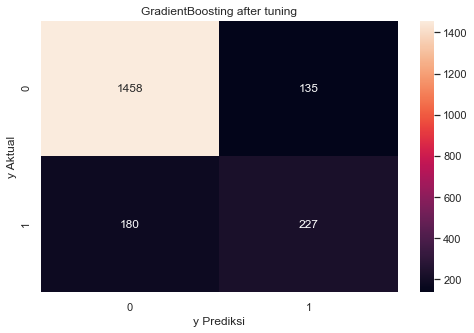

In [49]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_gbc_tuning), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('GradientBoosting after tuning');

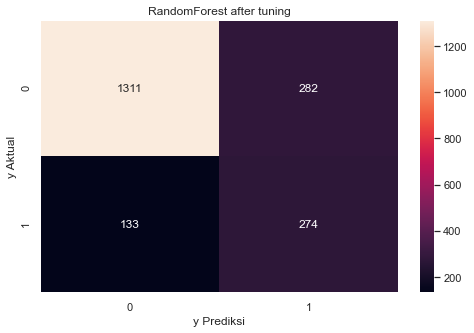

In [50]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf_tuning), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('RandomForest after tuning');

## **Summary**

The model with the highest metric value in case churn with the processing that has been done is Random Forest, with a recall value of 67%. The results obtained between before and after tuning differ quite significantly, where the tuning process helps optimize model performance. However, many false positives are generated in the Random Forest model after tuning (the precision value is very small), which is actually quite costly for the company. On the other hand, the GradientBoosting model has precision and recall values ​​that are not far apart. Therefore, the GBC model was chosen as the most optimal model in this churn case.

The recall metric is used because the cost function of false negatives is considered to be greater than false positives, so the number of false negatives generated by the model must be minimized. However, because the number of class 1 is only about 20% of the total data, using resampling technique alone is not enough to be able to produce a model with optimal performance, we must try other approaches, for example in combination with feature engineering.